 # Stock Market Anomaly Detection - A Machine Learning Approach! 


**Ved Bhatt (J009)** <br>
**Aditya Das (J016)**

**Anomaly detection** is an important concept in data science and machine learning. It involves identifying outliers or anomalies that do not conform to expected patterns in data.

**Stock market anomaly detection** is a critical process aimed at identifying unusual patterns or behaviors in stock data that deviate significantly from what's considered normal. These anomalies can signify important financial events, such as rapid price spikes, sudden crashes, or unusual trading volumes, which might be indicative of underlying issues or opportunities. 


In time series data specifically, anomaly detection aims to detect abnormal points that differ significantly from previous time steps.


<img src="https://wallpapers.com/images/hd/stock-market-world-map-3pkfoe2j58b9lkfo.jpg" alt="Alt text" title="Optional title" width="800" height="300"/>


<img src="https://img-b.udemycdn.com/course/750x422/645956_bd4f_5.jpg" alt="Alt text" title="Optional title" width="800" height="300"/>


## Contents

  - [Research objective](#Research-objective)
  - [Importing necessary libraries](#Importing-necessary-libraries)
- [Anomaly Detection](#Anomaly-Detection)
  - [1. Isolation Forest](#1.-Isolation-Forest)
  - [2. One Class SVM](#2.-One-Class-SVM)
  - [3. Autoencoders with LSTM](#3.-Autoencoders-with-LSTM)
    - [Anomaly Detection Mechanism](#Anomaly-Detection-Mechanism:)
  - [Trading Strategy](#Trading-strategy)
  - [Performance Analysis of Trading Strategy](#Performance-Analysis-of-Trading-Strategy)
  - [Conclusion](#Conclusion)

## Research objective

1. To develop robust machine learning models capable of detecting anomalies in stock market data, sourced from Yahoo finance.
2. Starting with basic models like Isolation Forest and One-Class SVM, and evaluating their effectiveness in anomaly detection.
3. Investigating the limitations of initial approaches and exploring advanced models, such as Autoencoders with LSTM (Long Short-Term Memory) networks, for improved anomaly detection.
4. Utilizing the detected anomalies to devise a trading strategy, generating actionable buy and sell signals to capitalize on market inefficiencies.
5. Analyzing the performance of trading strategy and providing the average risk-return and effectiveness of the Startegy.


## Importing necessary libraries

This cell is crucial for setting up the environment by importing necessary libraries and configuring settings to ensure smooth execution of the subsequent code. Libraries such as numpy and pandas are fundamental for data manipulation, yfinance fetches financial data, matplotlib and seaborn are used for plotting, and tensorflow along with sklearn are essential for machine learning and anomaly detection tasks. The warnings filter is adjusted to ignore warnings to keep the notebook tidy.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional
from tensorflow.keras import optimizers
import ta
import pymannkendall as mk
import tensorflow as tf
from scipy.stats import linregress

**Data Source:**
Utilizing Yahoo Finance - yfinance as the primary data source, ensuring access to historical stock market data of Google.


In this cell, we retrieve stock data for a specific ticker (GOOGL) using the yfinance library for a defined date range. The data is retrieved at a 1-hour interval, providing high granularity for analysis. This step is critical for acquiring the raw data required for subsequent analysis and modeling steps.

In [2]:
ticker = 'GOOGL'
start_date = '2024-01-27'
end_date = '2024-03-28'
df = yf.download(ticker, start_date, end_date,interval='1h')

[*********************100%%**********************]  1 of 1 completed


After retrieving the data, it's helpful to visualize the closing prices to get a sense of the data's behavior over time. This cell uses matplotlib to plot the Close prices, offering a visual inspection of the stock's price movement within the specified time frame. Such visualization is essential for preliminary analysis and spotting obvious anomalies or patterns.

<AxesSubplot:>

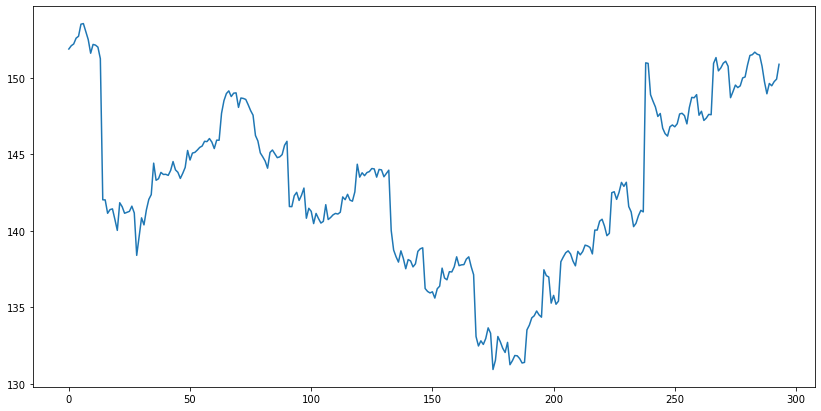

In [3]:
df.reset_index(inplace=True,drop=True)
plt.figure(figsize=(14, 7))

df['Close'].plot()

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
0,152.059998,152.839996,151.429993,151.899994,151.899994,6052455
1,151.904999,152.220001,151.490005,152.115005,152.115005,3326200
2,152.119995,152.369995,151.865005,152.229996,152.229996,2157461
3,152.240005,152.659897,152.229996,152.610001,152.610001,1916663
4,152.615005,152.830002,152.449997,152.735001,152.735001,1714018


# Anomaly Detection

Any data point/observation that deviates significantly from the other observations is called an Anomaly/Outlier. Anomaly detection is important and finds its application in various domains like Stock market deviations, detection of fraudulent bank transactions, network intrusion detection, sudden rise/drop in sales, change in customer behavior, etc.

* Various methods are employed for detecting such anomalies, ranging from statistical tests and time-series analysis to advanced machine learning techniques like Isolation Forests, One-Class SVMs, and neural network-based autoencoders. 

* Each method has its strengths and is chosen based on the specific characteristics of the data, including volume, volatility, and the presence of seasonal patterns. 

* Effective anomaly detection in stock markets not only aids in risk management by alerting investors to potential market manipulations or financial distress but also identifies opportunities for arbitrage. 

* Given the complex and dynamic nature of financial markets, continuously refining and adapting these detection strategies is crucial for maintaining their effectiveness over time.

## 1. Isolation Forest

Isolation Forests(IF), similar to Random Forests, are build based on decision trees. And since there are no pre-defined labels here, it is an unsupervised model.

In an Isolation Forest, randomly sub-sampled data is processed in a tree structure based on randomly selected features. The samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.

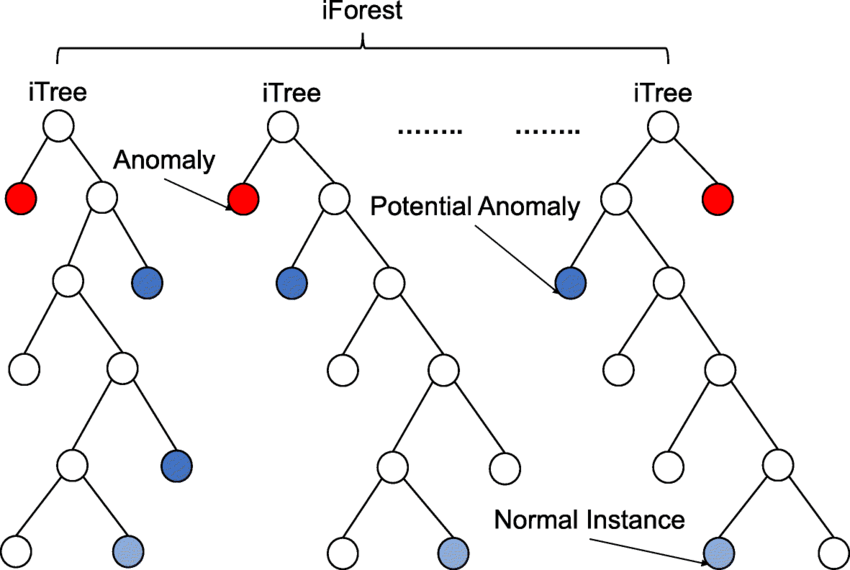

Here, we employ the Isolation Forest algorithm to detect anomalies in the stock data. The Isolation Forest is particularly suited for identifying outliers in datasets with complex structures. The code fits the model on selected features (Open, Close, High, Low, Volume) and determines anomalies based on a manual threshold. The detected anomalies are then visualized on the stock's closing price plot, providing an intuitive representation of unusual price movements.

The choice of threshold is critical and can significantly affect the detection outcome. A more negative threshold would mark fewer points as anomalies, while a threshold closer to zero might include more points as potential outliers.

A lower (more negative) threshold results in identifying fewer data points as anomalies, increasing the model's specificity but potentially missing some true anomalies (false negatives).

A higher threshold (closer to zero or positive) makes the model more sensitive, detecting more anomalies but also increasing the risk of false positives.

**That is why we have chosen a threshold of -0.01**

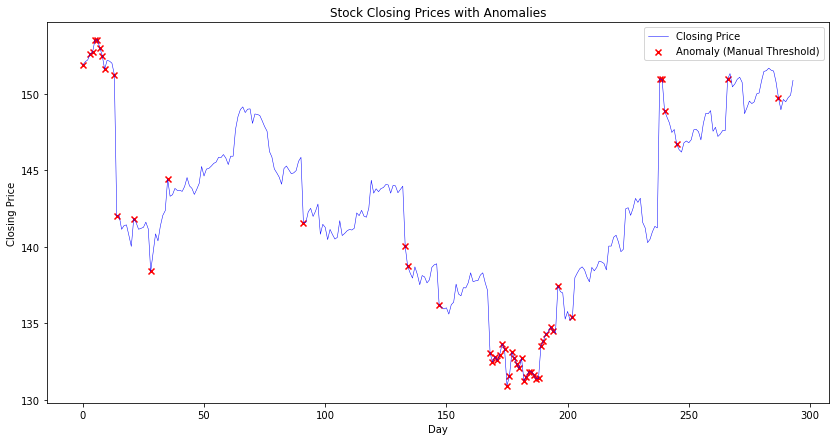

In [5]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

features = ['Open', 'Close', 'High', 'Low', 'Volume']
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

model.fit(df[features])

scores = model.decision_function(df[features])
threshold = -0.01  # We can adjust this based on our analysis

df['outlier_manual'] = scores < threshold

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue', linewidth=0.5)

anomalies_manual = df[df['outlier_manual']]
plt.scatter(anomalies_manual.index, anomalies_manual['Close'], color='red', label='Anomaly (Manual Threshold)', marker='x')

plt.title('Stock Closing Prices with Anomalies')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


**Result:** Here we can see the datapoints are giving anomalies perfectly along with some forming a cluster. 

## 2. One Class SVM

One Class Classification (OCC) aims to differentiate samples of one particular class by learning from single class samples during training. It is one of the most commonly used approaches to solve Anamoly Detection (AD), a subfield of machine learning that deals with identifying anomalous cases which the model has never seen before. OCC is also called unary classification, class-modelling.

**Parameters used** :
kernel='rbf': The Radial Basis Function (RBF) kernel is selected for its capability to handle non-linear data. It's a common choice for many types of SVM problems because it can map inputs into high-dimensional space, making it easier to linearly separate data points.

gamma='auto': This parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The 'auto' setting uses 1/n_features as the gamma value. It automatically adjusts gamma based on the number of features in your dataset, which can be a good starting point.

nu=0.1: Setting nu to 0.1 means that the algorithm is allowed to misclassify up to 10% of the data points as outliers, and at least 10% of the data points are support vectors. Adjusting nu can control the sensitivity of the model to outliers.


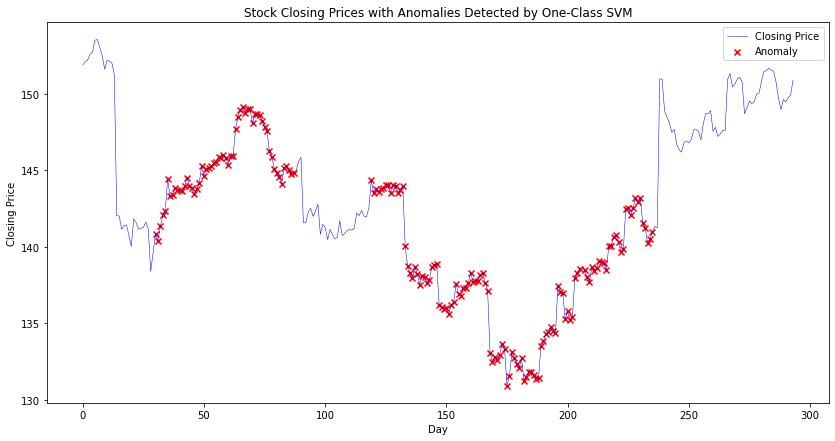

In [6]:
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)

# Note: One-Class SVM is an unsupervised algorithm, and it expects data in a specific format
# [-1 for outliers, 1 for inliers]
df['anomaly'] = model.fit_predict(df[features])

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue', linewidth=0.5)

# Highlight anomalies
anomalies = df[df['anomaly'] == -1]  # One-Class SVM marks outliers as -1
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomaly', marker='x')

plt.title('Stock Closing Prices with Anomalies Detected by One-Class SVM')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


**Result:** The results (as seen in above graph) are very much clusterred along the specifc data points and therefore not considerable.

## 3. Autoencoders with LSTM

**LSTM Autoencoders**:

LSTM stands for Long Short-Term Memory. LSTMs are a type of Recurrent Neural Network (RNN) designed to model temporal sequences and long-range dependencies more accurately than regular RNNs.

An autoencoder is a type of neural network designed to copy its input to its output. Internally, it has a hidden layer that encodes the input into a representation. By training the network to minimize the difference between the input and output, it learns efficient data encodings in the hidden layer.

An LSTM autoencoder combines both of these concepts. It uses LSTM layers to learn representations of temporal input sequences.

**Encoder:** The encoder part of the LSTM autoencoder compresses the input sequence into a lower-dimensional representation (latent space). This process involves learning the temporal dynamics and dependencies within the input data. LSTM layers are utilized here for their ability to remember long-term dependencies.


**Decoder:** The decoder part attempts to reconstruct the input sequence from the latent representation. The goal is to reconstruct the sequence as closely as possible, utilizing the same LSTM architecture to mirror the encoder's understanding of the temporal data.

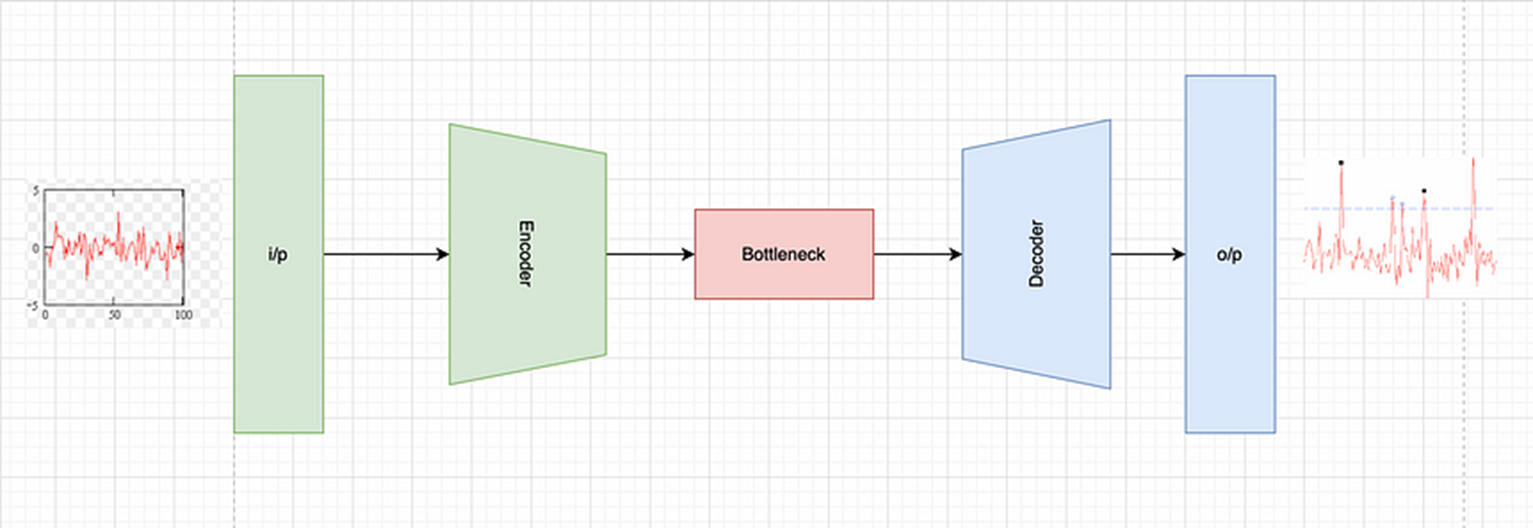

### Anomaly Detection Mechanism

**Reconstruction Error:** After training the autoencoder on normal data (data without anomalies), the model should be able to reconstruct similar data with low error. When the model encounters data that deviate significantly from the learned patterns (anomalies), the reconstruction error will be higher. Thus, the reconstruction error serves as an indicator of anomalies

However, when anomalous data is fed to the network, the decoder will not be able to reconstruct this data properly since the encoder did not see such patterns during training. The higher reconstruction error will indicate the presence of an anomaly.

Here are the steps to detect anomalies with LSTM autoencoders:

1. Train the autoencoder on normal time series data only
2. Determine a threshold for the reconstruction error above which a data point is considered anomalous
3. Feed new time-series data through the trained autoencoder
4. If reconstruction error exceeds the threshold for any data point, label it an anomaly
5. Setting an optimal threshold is important here to accurately classify anomalies every time.

**Model Architecture**

The encoder consists of two LSTM layers with 32 and 16 units, respectively. The activation='linear' is chosen, likely for simplicity and to maintain a linear scale of input features through the encoding process. return_sequences=True in the first LSTM layer allows the sequence output to be passed to the next LSTM layer, capturing temporal dependencies at different granularities.

The decoder mirrors the encoder's architecture but in reverse, aiming to reconstruct the input sequence from the encoded representation. RepeatVector repeats the encoder's output to match the expected number of time steps in the input, facilitating the reconstruction process. The TimeDistributed wrapper around the Dense layer allows applying the dense operation to each time step independently, reconstructing the feature values at each step.

Threshold Setting: A threshold for the reconstruction error is set to distinguish between normal data and anomalies. Data points with a reconstruction error above this threshold are marked as anomalies.


In [7]:
df=df.iloc[:,0:6]
def autoLSTM(df):
    input_shape = (df.shape[1], 1)
    input_layer = Input(shape=input_shape)
    encoder = LSTM(32, activation='linear', return_sequences=True)(input_layer)
    encoder_1 = LSTM(16, activation='linear')(encoder)
    repeat = RepeatVector(input_shape[0])(encoder_1)
    decoder = LSTM(16, activation='linear', return_sequences=True)(repeat)
    decoder_1 = LSTM(32, activation='linear', return_sequences=True)(decoder)
    output_layer = TimeDistributed(Dense(input_shape[1]))(decoder_1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(df, df, epochs=25, batch_size=100,verbose=0)
    predictions = model.predict(df)
    predictions=predictions.reshape(predictions.shape[0],predictions.shape[1])
    return predictions
predictions=autoLSTM(df)

10/10 [==============================] - 1s 4ms/step


**Anomaly Detection**

The `anomaly` function identifies anomalies in stock market data by calculating the Mean Squared Error (MSE) between the actual values and predictions from an autoencoder model. It uses this discrepancy to pinpoint data points that significantly deviate from expected patterns. By setting a threshold at the 95th percentile of the MSE values, it flags the top 5% as anomalies. These outliers are marked within the dataset, facilitating their identification and analysis. 

The function ultimately generates a list of anomaly indices, offering a practical tool for highlighting unusual market behaviors or inefficiencies that could signal trading opportunities or necessitate model adjustments. This concise mechanism enriches financial data analysis, enabling a focused investigation into deviations that could unveil critical insights into market dynamics.

In [8]:
def anomaly(df,predictions):
    mse = np.mean(np.power(df - predictions, 2), axis=1)
    threshold = np.percentile(mse,95)
    anomalies = np.where(mse > threshold)[0]
    anomalies_indices = [idx for idx in anomalies if idx < len(df)]
    df['anomaly'] = 0
    df.loc[anomalies_indices,'anomaly'] = 1
    return anomalies_indices
anomalies_indices=anomaly(df,predictions)

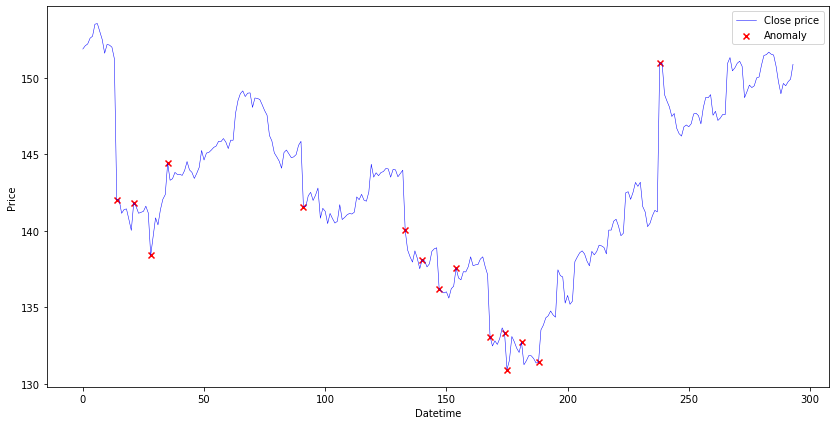

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close price', color='blue', linewidth=0.5)
plt.scatter(df.iloc[anomalies_indices].index, df.iloc[anomalies_indices]['Close'], color='red', label='Anomaly', marker='x')

plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()


**Result:** The graphs perfectly points the anomalies in the data. Here, there is no clustering of points and outlier markers are very much defined near the trend reversal points 

Therefore, we will be going forward with **Autoencoders with LSTM as the most accurate algorithm** for detecting the Anomalies of our input Stock.

**Moving Average Convergence**

The `cross` function identifies moving average crossovers in stock data, a key technique in technical trading strategies. It calculates short-term (5 periods) and long-term (20 periods) moving averages (MAs) of closing prices, then detects crossovers—points where the short-term MA crosses the long-term MA. 

These crossovers signal potential buy or sell opportunities, indicating shifts in market momentum. The function flags these moments and returns their indices, offering a concise tool for traders to pinpoint market sentiment changes and make informed trading decisions. Through this streamlined approach, the cross function simplifies the integration of moving average analysis into trading strategies, enhancing the ability to capture market trends and shifts.

In [10]:
def cross(df):
    df['slow'] = df['Close'].rolling(window=20).mean()
    df['fast'] = df['Close'].rolling(window=5).mean()
    df['crossover'] = (((df['fast'] > df['slow']) & (df['fast'].shift(1) <= df['slow'].shift(1))) |
                   ((df['fast'] < df['slow']) & (df['fast'].shift(1) >= df['slow'].shift(1)))).astype(int)
    converges_indices = df.index[df['crossover'] == 1]
    return converges_indices
converges_indices=cross(df)

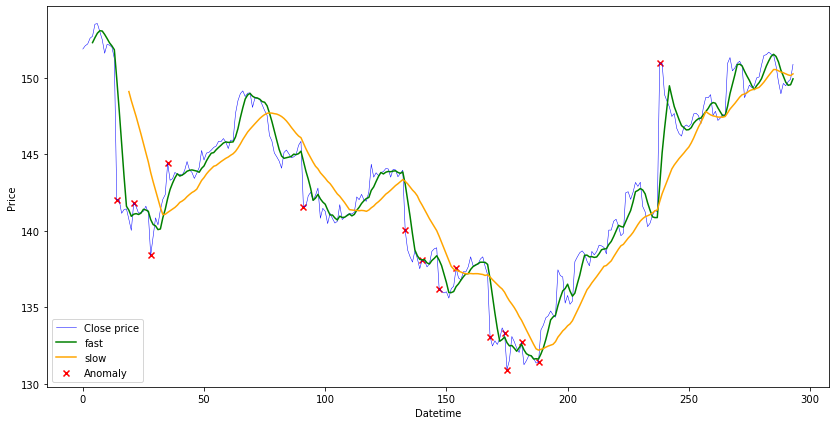

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close price', color='blue', linewidth=0.5)
plt.scatter(df.iloc[anomalies_indices].index, df.iloc[anomalies_indices]['Close'], color='red', label='Anomaly', marker='x')

# Plot SMA
plt.plot(df.index, df['fast'], label='fast', color='green')
plt.plot(df.index, df['slow'], label='slow', color='orange')

plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

**Anomaly and Crossover Integration**

The `anc` function synergizes anomaly detection with moving average crossover analysis by locating anomalies near crossover points within stock market data. It iterates through each crossover index and searches for anomaly indices that fall within a predefined proximity range of ±18 time units, aiming to capture significant market movements influenced by both technical indicators and outlier events. 

The function compiles these relevant anomaly indices, ensuring no duplicates, and sorts them to maintain chronological order. The output is a refined list of indices where both anomalies and crossovers converge, offering a focused lens for examining potential market turning points or trading opportunities. This approach enhances trading strategies by integrating the precision of anomaly detection with the momentum insight provided by moving average crossovers.

In [11]:
def anc(converges_indices,anomalies_indices):
    indices = []
    # Loop through each element in converges_indices
    for converge_index in converges_indices:
        # Find the nearest anomaly index within +/- 18 range of each converge_index
        nearest_anomalies = [anomaly_index for anomaly_index in anomalies_indices 
                             if abs(anomaly_index - converge_index) <= 17]
        # Extend the 'indices' list with these nearest anomalies (if not already included)
        indices.extend(x for x in nearest_anomalies if x not in indices)

    # Sort the indices list to maintain order
    indices.sort()
    return indices
indices=anc(converges_indices,anomalies_indices)

## Trading Strategy

The `strategy` function analyzes market momentum around key indices, identified as potential trading opportunities, to generate actionable trading signals. It calculates the slopes of closing prices before and after each index within a 3-day window to determine price trends. If the trend shifts from downward to upward, it signals a "Buy" opportunity, indicating rising momentum. Conversely, a shift from upward to downward trend signals a "Sell" opportunity, suggesting declining momentum. This method systematically identifies precise moments to enter or exit trades, based on short-term price movements, optimizing decision-making in trading strategies.

In [13]:
def strategy(indices,df):
    strategy={}
    for i in indices:
        k=3
        
        # Extract closing prices for the lookback window and lookahead window
        a=df['Close'].iloc[i-k:i]
        b=df['Close'].iloc[i:i+k]
        x = list(range(1, k + 1))
        
        # Perform linear regression on the lookback and lookahead windows to get their slopes
        slope_a, intercept_a, r_value_a, p_value_a, std_err_a = linregress(x, a)
        slope_b, intercept_b, r_value_b, p_value_b, std_err_b = linregress(x, b)
        
        if slope_a < 0 and slope_b > 0: # If the slope changes from negative to positive mark as a Buy signal
            strategy[i]='Buy'
        elif slope_a > 0 and slope_b < 0: # If the slope changes from positive to negative Mark as a Sell signal
            strategy[i]='Sell'
    return strategy
strategy=strategy(indices,df)

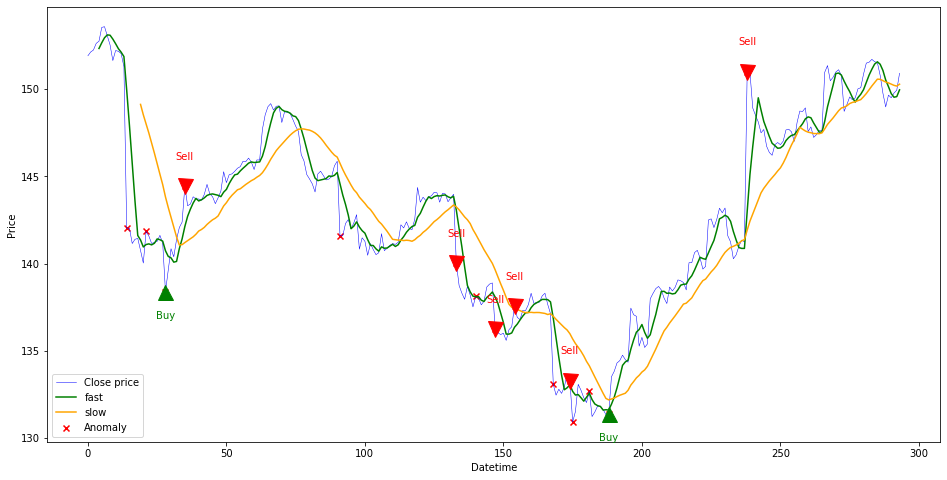

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close price', color='blue', linewidth=0.5)
plt.scatter(df.iloc[anomalies_indices].index, df.iloc[anomalies_indices]['Close'], color='red', label='Anomaly', marker='x')

# Plot SMA
plt.plot(df.index, df['fast'], label='fast', color='green')
plt.plot(df.index, df['slow'], label='slow', color='orange')

# Mark the strategy points with big triangles and labels
for idx, action in strategy.items():
    y_position = df['Close'].iloc[idx]
    text_offset = df['Close'].max() * 0.01  # Adjust the offset as needed

    if action == 'Sell':
        # Sell action: Red triangle pointing downwards
        plt.plot(df.index[idx], y_position, marker='v', markersize=15, color='red')
        plt.text(df.index[idx], y_position + text_offset, 'Sell', color='red', ha='center')
    elif action == 'Buy':
        # Buy action: Green triangle pointing upwards
        plt.plot(df.index[idx], y_position, marker='^', markersize=15, color='green')
        plt.text(df.index[idx], y_position - text_offset, 'Buy', color='green', ha='center')

plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

## Performance Analysis of Trading Strategy

The `calculate_risk_return` function computes the average return and risk (standard deviation of returns) of a trading strategy. It iterates through each trade identified by the strategy, calculating returns from 'Buy' to 'Sell' signals, and then aggregates these to find the overall performance metrics. 

The `calculate_sharpe_ratio` function further evaluates the strategy's effectiveness by calculating its Sharpe ratio, a measure of risk-adjusted return, using the average return, the risk of the strategy, and a specified risk-free rate. Together, these functions provide a comprehensive analysis of a trading strategy's profitability, consistency, and efficiency in risk management, essential for assessing and refining investment decisions.

In [19]:
def calculate_risk_return(strategy, df):
    returns = []
    buy_price = None
    for idx, action in strategy.items():
        if action == 'Buy':
            buy_price = df['Close'].iloc[idx]
        elif action == 'Sell' and buy_price is not None:
            sell_price = df['Close'].iloc[idx]
            trade_return = (sell_price - buy_price) / buy_price
            returns.append(trade_return)
            buy_price = None  # Reset for next trade
    average_return = np.mean(returns)
    risk = np.std(returns)
    return average_return, risk

def calculate_sharpe_ratio(average_return, risk, risk_free_rate=0.01):
    sharpe_ratio = (average_return - risk_free_rate) / risk
    return sharpe_ratio
average_return, risk = calculate_risk_return(strategy, df)
sharpe_ratio = calculate_sharpe_ratio(average_return, risk, 0.01)

print(f"Average Return: {average_return}")
print(f"Risk (Volatility): {risk}")
print(f"Sharpe Ratio: {sharpe_ratio}")

Average Return: 0.09640960929138881
Risk (Volatility): 0.05280262770237774
Sharpe Ratio: 1.6364641884573812


**Results from Anomaly-Based Trading Strategy**

1. **Profitability**: The strategy demonstrates clear profitability with an average return of **9.64%**, indicating its effectiveness in leveraging market anomalies for gains.

2. **Risk Management**: A volatility of **5.28%** suggests a moderate risk level, pointing towards a balanced approach in pursuit of profitable trades while maintaining risk within a manageable range.

3. **Efficient Use of Capital**: With a Sharpe ratio of **1.64**, the strategy shows strong risk-adjusted performance, implying that investors are adequately compensated for the risks taken.

In essence, the promising average return, managed volatility, and robust Sharpe ratio collectively signal a well-devised and executed trading strategy based on anomaly detection.


## Conclusion

The analysis of stock market anomalies using machine learning techniques like LSTM autoencoders has demonstrated a compelling approach to identifying and capitalizing on market inefficiencies. With an average return of **9.64%** and a Sharpe ratio of **1.64**, the strategy not only promises profitability but also maintains a balanced risk profile. This underscores the effectiveness of leveraging machine learning for financial analysis, offering a potent blend of risk management and return optimization.

Furthermore, the results advocate for the integration of advanced analytics in trading, where the precision of anomaly detection and the strategic use of moving averages can significantly enhance trading decisions. The success of these machine learning models in navigating the complexities of the stock market suggests a promising avenue for future financial strategies, highlighting the critical role of continuous model improvement and the exploration of new data inputs to sustain and improve market performance.